In [1]:
## Callin Switzer

## add points to a movie
## Extra Requirements: 
## -- opencv (to read and write video frames)
## -- ffmpeg (to convert video frames to a full movie)

In [2]:
import numpy as np
import cv2
import matplotlib
#matplotlib.use("TkAgg") # have to use this for tkinter to  work below
from matplotlib import pyplot as plt
%matplotlib inline
import skimage.io as io
import os
import time
import sys
from datetime import datetime
import pandas as pd

print("opencv version: %s" % cv2.__version__)
print("python version: %s" % sys.version[0:6])
print("last run: %s" % datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

opencv version: 3.4.1
python version: 3.6.5 
last run: 2019-05-10 10:01:13


In [3]:
# adjust gamma, if your vid is too dark
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
 
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

In [193]:
# read in video
vidPath = r"D:\Dropbox\AcademiaDropbox\dataAnalysisForOthers\MahadMovies\L0.1_c-3_m12.mp4"
if not os.path.isfile(vidPath): print("video doesn not exist")

dataPath = r"D:\Dropbox\AcademiaDropbox\dataAnalysisForOthers\MahadMovies\Final_position_centroid_method_FirstTrial_L0.1_c-3_m12.csv"
#dataPath = r"D:\Dropbox\AcademiaDropbox\dataAnalysisForOthers\MahadMovies\Final_position_centroid_method_LastTrial_L0.1_c-3_m12.csv"
if not os.path.isfile(dataPath): 
    print("dataset doesn not exist")
    
else:
    dataPoints = pd.read_csv(dataPath, index_col  = 0)

dataPoints.head()

,FrameNumber,Name,X_position,Y_position
0,26059,L0.1_c-3_m12,NaN,NaN
1,26060,L0.1_c-3_m12,633.0,81.0
2,26061,L0.1_c-3_m12,633.0,23.0
3,26062,L0.1_c-3_m12,615.0,84.0
4,26063,L0.1_c-3_m12,626.0,137.0


In [194]:
# get vid info
cap = cv2.VideoCapture(vidPath)

length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = cap.get(cv2.CAP_PROP_FPS)

print(length, width, height, fps)
cap.release()

97782 648 488 30.0


In [195]:
# data cleaning


In [196]:
dataPoints["X_filled"] = dataPoints["X_position"].interpolate().fillna(method = "ffill").fillna(method = "bfill")
dataPoints["Y_filled"] = dataPoints["Y_position"].interpolate().fillna(method = "ffill").fillna(method = "bfill")
dataPoints.head()

,FrameNumber,Name,X_position,Y_position,X_filled,Y_filled
0,26059,L0.1_c-3_m12,NaN,NaN,633.0,81.0
1,26060,L0.1_c-3_m12,633.0,81.0,633.0,81.0
2,26061,L0.1_c-3_m12,633.0,23.0,633.0,23.0
3,26062,L0.1_c-3_m12,615.0,84.0,615.0,84.0
4,26063,L0.1_c-3_m12,626.0,137.0,626.0,137.0


In [197]:
def load_imgs(vidPath, firstFrame, lastFrame):
    '''
    Reads frames from video and stores as a list
    
    Parameters: 
    vidPath (string): Path to video
    
    Returns: 
    list of images
    '''
    
    cap = cv2.VideoCapture(vidPath)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    imgs = []
    for ff in range(length):
        ret, frame = cap.read()
        if ff < firstFrame:
            continue
        elif ff >= lastFrame:
            break
        else:
            if np.mod(ff, 50) == 0:
                print(ff) # prints progress in 50 frames

            # convert to grey
            #img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            imgs.append(frame)
            
    cap.release()
    return imgs


# load images
imList = load_imgs(vidPath, np.min(dataPoints.FrameNumber), np.max(dataPoints.FrameNumber))

26100
26150
26200
26250
26300
26350
26400
26450
26500
26550
26600
26650
26700
26750
26800
26850
26900
26950
27000
27050
27100
27150
27200
27250
27300
27350
27400


In [198]:
# smooth with a rolling mean
dataPoints["Y_smoothed"] = dataPoints["Y_filled"].rolling(21, min_periods = 1, center = True).mean()
dataPoints["X_smoothed"] = dataPoints["X_filled"].rolling(21, min_periods = 1, center = True).mean()

In [207]:
# here's a little more smoothing -- a lowpass filter
# smooth data
from scipy import signal
b, a = signal.butter(10, 0.4, btype="low")

# Applies filter forward and backward in time
dataPoints["Y_smoothed2"] = signal.filtfilt(b, a, dataPoints.Y_smoothed)
dataPoints["X_smoothed2"] = signal.filtfilt(b, a, dataPoints.X_smoothed)

In [208]:
dataPoints.head()

,FrameNumber,Name,X_position,Y_position,X_filled,Y_filled,Y_smoothed,X_smoothed,Y_smoothed2,X_smoothed2
0,26059,L0.1_c-3_m12,NaN,NaN,633.0,81.0,127.272727,619.454545,127.272458,619.453498
1,26060,L0.1_c-3_m12,633.0,81.0,633.0,81.0,134.000000,617.666667,134.272570,617.733192
2,26061,L0.1_c-3_m12,633.0,23.0,633.0,23.0,140.846154,616.384615,140.640403,616.503656
3,26062,L0.1_c-3_m12,615.0,84.0,615.0,84.0,146.428571,615.928571,146.371287,615.808183
4,26063,L0.1_c-3_m12,626.0,137.0,626.0,137.0,151.866667,615.333333,152.013436,615.265333


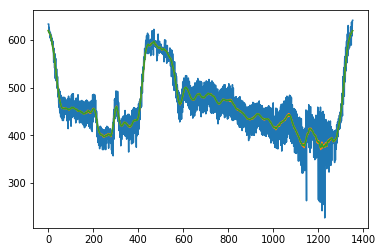

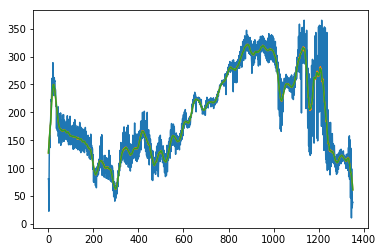

In [209]:
plt.plot(dataPoints.X_filled)
plt.plot(dataPoints["X_smoothed"])
plt.plot(dataPoints["X_smoothed2"])
plt.show()

plt.plot(dataPoints.Y_filled)
plt.plot(dataPoints["Y_smoothed"])
plt.plot(dataPoints["Y_smoothed2"])
plt.show()


(0, 488)

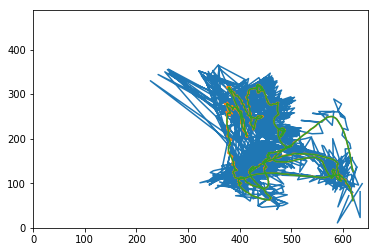

In [210]:
plt.plot(dataPoints.X_position, dataPoints.Y_position)
plt.plot(dataPoints.X_smoothed, dataPoints.Y_smoothed)
plt.plot(dataPoints.X_smoothed2, dataPoints.Y_smoothed2)
plt.xlim([0, width])
plt.ylim([0, height])

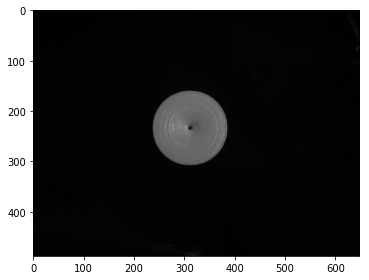

In [211]:
# show first image
io.imshow(imList[0])

In [212]:
imList[0].shape

(488, 648, 3)

In [213]:
# make directory to store images
tempImgDirectory = os.path.join(os.path.dirname(vidPath), "tmpImgs")
if not os.path.exists(tempImgDirectory):
    os.mkdir(tempImgDirectory)

# add circles up to XX points in the past

lagPoints = 200 # number of points to plot on each frame
alphaVals = np.flip(np.linspace(0, 0.2, lagPoints), axis = 0)
vidLen = len(imList)
outputImgs = []
for frameNum in np.arange(0, vidLen):
    
    # adjust gamma
    image = adjust_gamma(imList[frameNum], 1.5)
    
    # convert to rgb, so I can add colored points
    #image = cv2.cvtColor(im1,cv2.COLOR_GRAY2RGB)
    
    
    overlay = image.copy()
    output = image.copy()
    for jj in range(lagPoints):
        # add circle, centered at closest integer value
        cv2.circle(overlay, (int(dataPoints.X_smoothed2[np.max([frameNum-jj, 0])]), 
                             int(dataPoints.Y_smoothed2[np.max([frameNum-jj, 0])])), 
                   3, (219, 189, 166), -1)
        cv2.addWeighted(overlay, alphaVals[jj], output, 1 - alphaVals[jj],0, output)
    
    # invert color
    # output = cv2.bitwise_not(output)
    
    
    outputImgs.append(output)
    
    # display image -- it may be a bit faster if you don't display the images
    cv2.imshow('Output', output) 
     
    # save img
    cv2.imwrite(os.path.join(tempImgDirectory, str(frameNum).zfill(4) + ".png"), output)
    
    # Press Q on keyboard to  exit 
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break
    
    if np.mod(frameNum, 50) == 0:
        print(frameNum, " of ", vidLen)

cv2.destroyAllWindows()

0  of  1352
50  of  1352
100  of  1352
150  of  1352
200  of  1352
250  of  1352
300  of  1352
350  of  1352
400  of  1352
450  of  1352
500  of  1352
550  of  1352
600  of  1352
650  of  1352
700  of  1352
750  of  1352
800  of  1352
850  of  1352
900  of  1352
950  of  1352
1000  of  1352
1050  of  1352
1100  of  1352
1150  of  1352
1200  of  1352
1250  of  1352
1300  of  1352
1350  of  1352


In [15]:
# # you can make images larger: 
# output = cv2.resize(output, (width*2, height*2), interpolation=cv2.INTER_CUBIC)

In [170]:
# show a single image
cv2.namedWindow('Output')
cv2.imshow("Output", output)

# # destroy the window when the mouse clicks the "X"
while cv2.getWindowProperty('Output', cv2.WND_PROP_VISIBLE) == 1:
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break
cv2.destroyAllWindows()

In [214]:
# convert images to video with ffmpeg
os.chdir(tempImgDirectory)
print(tempImgDirectory)
# use ffmpeg to convert directory to video
# -r is output frame rate
os.system('ffmpeg -start_number 0 -r 50 -i %04d.png -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -c:v libx264 -pix_fmt yuv420p -y outputVid3.mp4')

D:\Dropbox\AcademiaDropbox\dataAnalysisForOthers\MahadMovies\tmpImgs


0

In [215]:
# delete images from directory
delFiles = [f for f in os.listdir(tempImgDirectory) if f.endswith("png")]

dlfs = [os.remove(os.path.join(tempImgDirectory, delFiles[ii])) for ii in range(len(delFiles))]